In [1]:
import numpy as np
from pathlib import Path
import scipy.io as sio
from scipy.interpolate import interp2d
import imageio
import cv2
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import time

from skimage import data, draw
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.transform import warp

from spyrit.misc.disp import *
from spyrit.misc.metrics import *
from spyrit.learning.dataset import *


In [2]:
data_root = "../../data/UCF-101";
dataset_path="../../data/UCF-101-frames";
split_path="../../data/ucfTrainTestlist";
batch_size=20;
img_size=64;
num_frames=21;
dt = 1/25;
dx = 1/img_size;

np.random.seed(seed=0)

In [3]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.FloatTensor;
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
image_shape = (1, img_size, img_size)




# Define training set
train_dataset = Dataset_prediction(
    dataset_path = dataset_path,
    split_path = split_path,
    split_number = 1,
    input_shape = image_shape,
    sequence_length = num_frames,
    training = True,
)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)
# Define test set
test_dataset = Dataset_prediction(
    dataset_path = dataset_path,
    split_path = split_path,
    split_number = 1,
    input_shape = image_shape,
    sequence_length = num_frames,
    training=False,
)
testloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 4)
dataloaders = {'train':trainloader, 'val':testloader};

/home/lorente/.conda/envs/spyrit-env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [4]:
# from scipy.interpolate import interpn
from scipy.interpolate import griddata, RectBivariateSpline


def warp_zero(I1, flow):
    nr, nc = I1.shape
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
    image1_warp = warp(I1, np.array([row_coords - flow[:,:,0], col_coords - flow[:,:,1]]), mode='edge', preserve_range=True);
    return image1_warp;

def warp_un(I1, flow):
    nx, ny = I1.shape
    x = np.linspace(1, nx, nx);
    y = np.linspace(1, ny, ny);
    X, Y = np.meshgrid(x, y);
    I2 = griddata((np.reshape(X,(nx*ny)),np.reshape(Y,(nx*ny))), np.reshape(I1,(nx*ny)), (X+flow[:,:,0],Y+flow[:,:,1]), method='cubic', fill_value = 0);
    return I2;

def warp_bis(I1, flow):
    """Bonne fonction pour faire ce qui nous intéresse!"""
    h, w = flow.shape[:2];
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    I2 = cv2.remap(I1, flow, None, cv2.INTER_LINEAR);
    return I2;


def float2_bit(I):
    I_8_bit = 255*(I+1)/2
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

def float2_bit_gen(I):
    I_8_bit = 255*(I-np.amin(I))/(np.amax(I)-np.amin(I))
    I_8_bit = I_8_bit.astype('uint8')
    return I_8_bit

# Test on Real Videos

In [5]:
A = next(iter(testloader));

In [6]:
x = A[0][0,:,:,:,:];
I1 = torch2numpy(x[3,0,:,:]);
I2 = torch2numpy(x[4,0,:,:]);

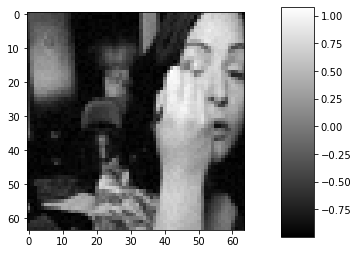

In [7]:
imagesc(I1)

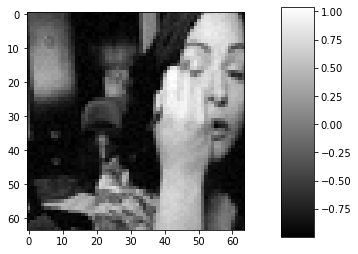

In [8]:
imagesc(I2)

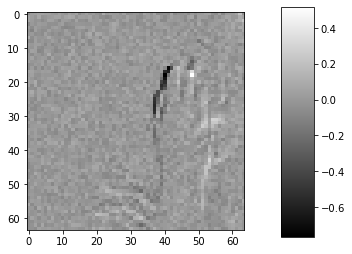

In [9]:
imagesc(I1-I2)

In [10]:
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create(nscales=1,epsilon=0.05,warps=1, innnerIterations = 10);
optical_flow.setLambda(0.005) #0.005 is the breaking point
t1 = time.time();
flow = optical_flow.calc(I1, I2, None);
t2 = time.time();

In [11]:
t2-t1

0.0013537406921386719

In [12]:
u = flow[:,:,0];
v = flow[:,:,1];

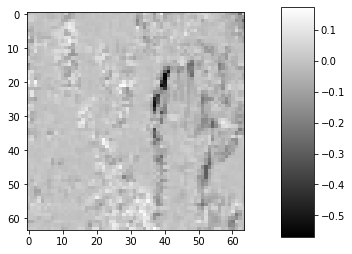

In [13]:
imagesc(u)

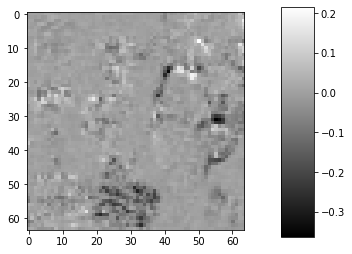

In [14]:
imagesc(v)

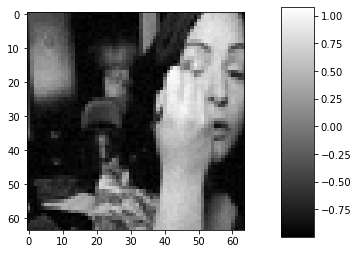

In [15]:
imagesc(warp_bis(I1,dt*flow))

In [16]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");

I2_zero = warp_zero(I1,dt*flow);
I2_zero_check = warp_zero(I1,-dt*flow);
I2_un = warp_un(I1,dt*flow);
I2_un_check = warp_un(I1,-dt*flow);
I2_bis = warp_bis(I1,dt*flow);
I2_bis_check = warp_bis(I1,-dt*flow);

print("===========================================");
print("Warp error Skimage dt = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dt = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dt = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dt = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dt = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dt = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,dx*flow);
I2_zero_check = warp_zero(I1,-dx*flow);
I2_un = warp_un(I1,dx*flow);
I2_un_check = warp_un(I1,-dx*flow);
I2_bis = warp_bis(I1,dx*flow);
I2_bis_check = warp_bis(I1,-dx*flow);

print("===========================================");
print("Warp error Skimage dx = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dx = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dx = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dx = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dx = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dx = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,flow);
I2_zero_check = warp_zero(I1,-flow);
I2_un = warp_un(I1,flow);
I2_un_check = warp_un(I1,-flow);
I2_bis = warp_bis(I1,flow);
I2_bis_check = warp_bis(I1,-flow);

print("===========================================");
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");


Identity error = 4.3338737
Warp error Skimage dt = 4.3060594
Warp error Skimage -dt = 4.349416
Warp error scipy dt = 7.611091484324203
Warp error scipy -dt = 9.604926171624049
Warp error opencv dt = 4.3656526
Warp error opencv -dt = 4.288223
Warp error Skimage dx = 4.32289
Warp error Skimage -dx = 4.3398347
Warp error scipy dx = 7.582046143988824
Warp error scipy -dx = 9.626839922841704
Warp error opencv dx = 4.3338737
Warp error opencv -dx = 4.3338737
Warp error Skimage = 3.946275
Warp error Skimage = 4.9223747
Warp error scipy = 8.91511801017922
Warp error scipy = 9.069348147203392
Warp error opencv = 5.993563
Warp error opencv = 39.751537


In [17]:
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);


# I1_8_bit = 255*(I1+1)/2
# I1_8_bit = I1_8_bit.astype('uint8')
# I2_8_bit = 255*(I2+1)/2
# I2_8_bit = I2_8_bit.astype('uint8')

In [18]:
t1 = time.time();
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 10, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 10 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [19]:
t2-t1

0.0017099380493164062

In [20]:
u = flow[:,:,0];
v = flow[:,:,1];

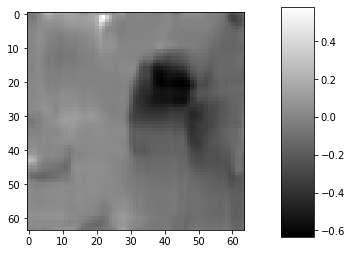

In [21]:
imagesc(u)

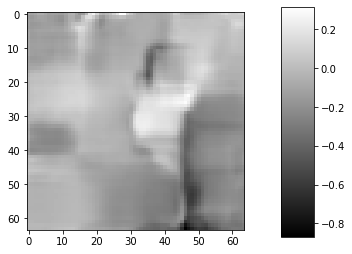

In [22]:
imagesc(v)

In [23]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");

I2_zero = warp_zero(I1,dt*flow);
I2_zero_check = warp_zero(I1,-dt*flow);
I2_un = warp_un(I1,dt*flow);
I2_un_check = warp_un(I1,-dt*flow);
I2_bis = warp_bis(I1,dt*flow);
I2_bis_check = warp_bis(I1,-dt*flow);

print("===========================================");
print("Warp error Skimage dt = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dt = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dt = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dt = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dt = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dt = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,dx*flow);
I2_zero_check = warp_zero(I1,-dx*flow);
I2_un = warp_un(I1,dx*flow);
I2_un_check = warp_un(I1,-dx*flow);
I2_bis = warp_bis(I1,dx*flow);
I2_bis_check = warp_bis(I1,-dx*flow);

print("===========================================");
print("Warp error Skimage dx = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dx = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dx = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dx = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dx = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dx = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,flow);
I2_zero_check = warp_zero(I1,-flow);
I2_un = warp_un(I1,flow);
I2_un_check = warp_un(I1,-flow);
I2_bis = warp_bis(I1,flow);
I2_bis_check = warp_bis(I1,-flow);

print("===========================================");
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");


Identity error = 4.3338737
Warp error Skimage dt = 4.2935414
Warp error Skimage -dt = 4.344166
Warp error scipy dt = 6.9311416563101345
Warp error scipy -dt = 10.07802736721163
Warp error opencv dt = 4.380241
Warp error opencv -dt = 4.2463193
Warp error Skimage dx = 4.3176665
Warp error Skimage -dx = 4.337431
Warp error scipy dx = 6.895029469113686
Warp error scipy -dx = 10.101583628184192
Warp error opencv dx = 4.3338737
Warp error opencv -dx = 4.3338737
Warp error Skimage = 4.5080585
Warp error Skimage = 5.5257864
Warp error scipy = 8.741298790066777
Warp error scipy = 9.622266305115561
Warp error opencv = 6.5341296
Warp error opencv = 39.258366


In [24]:
np.random.seed(seed=1)
t1 = time.time();
flow = cv2.optflow.calcOpticalFlowSparseToDense(I1_8_bit, I2_8_bit, None); # Pas forcément top
t2 = time.time();

In [25]:
t2-t1

0.004215240478515625

In [26]:
u = flow[:,:,0];
v = flow[:,:,1];

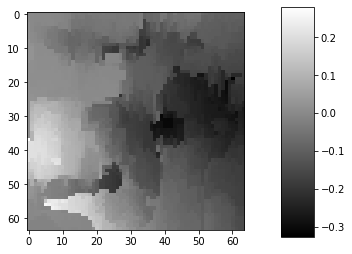

In [27]:
imagesc(u)

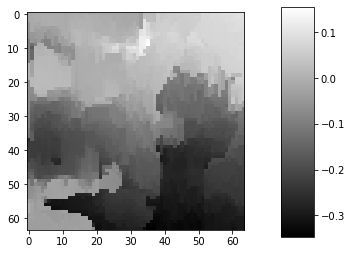

In [28]:
imagesc(v)

In [29]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");

I2_zero = warp_zero(I1,dt*flow);
I2_zero_check = warp_zero(I1,-dt*flow);
I2_un = warp_un(I1,dt*flow);
I2_un_check = warp_un(I1,-dt*flow);
I2_bis = warp_bis(I1,dt*flow);
I2_bis_check = warp_bis(I1,-dt*flow);

print("===========================================");
print("Warp error Skimage dt = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dt = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dt = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dt = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dt = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dt = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,dx*flow);
I2_zero_check = warp_zero(I1,-dx*flow);
I2_un = warp_un(I1,dx*flow);
I2_un_check = warp_un(I1,-dx*flow);
I2_bis = warp_bis(I1,dx*flow);
I2_bis_check = warp_bis(I1,-dx*flow);

print("===========================================");
print("Warp error Skimage dx = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dx = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dx = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dx = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dx = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dx = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,flow);
I2_zero_check = warp_zero(I1,-flow);
I2_un = warp_un(I1,flow);
I2_un_check = warp_un(I1,-flow);
I2_bis = warp_bis(I1,flow);
I2_bis_check = warp_bis(I1,-flow);

print("===========================================");
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");


Identity error = 4.3338737
Warp error Skimage dt = 4.3014827
Warp error Skimage -dt = 4.3457866
Warp error scipy dt = 6.63776270423072
Warp error scipy -dt = 10.289187434669348
Warp error opencv dt = 4.3338737
Warp error opencv -dt = 4.3338737
Warp error Skimage dx = 4.320869
Warp error Skimage -dx = 4.3381
Warp error scipy dx = 6.617947546197896
Warp error scipy -dx = 10.300975676551433
Warp error opencv dx = 4.3338737
Warp error opencv -dx = 4.3338737
Warp error Skimage = 4.4334517
Warp error Skimage = 5.512589
Warp error scipy = 7.810773256281219
Warp error scipy = 10.132408632652009
Warp error opencv = 5.7154536
Warp error opencv = 39.470108


It seems to compute that `I3_check = warp_bis(I1,-dt*flow);` is the correct one

# Test on synthetic video

In [30]:
def boule_vid_parabola(n, r, n_frames, v):
    x = np.linspace(-1, 1, n);
    y = np.linspace(-1, 1, n);
    X, Y = np.meshgrid(x, y);
    Vid = np.zeros((n_frames,n,n))
    for i in range(n_frames):
        t = v*i/n_frames;
        x_c = t;
        y_c =  t*(t-1);
        msk = 1.0*((X-x_c)**2+(Y-y_c)**2<r);
        Vid[i,:,:] = msk;
    return Vid;

In [31]:
n_frames = 10;
A = boule_vid_parabola(64, 0.025, n_frames, 1)
A = torch.Tensor(A);
A = torch2numpy(A)

In [32]:
dt = 1/n_frames

In [33]:
A.shape

(10, 64, 64)

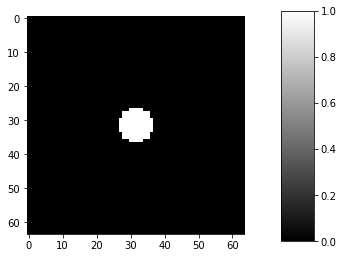

In [34]:
imagesc(A[0,:,:])

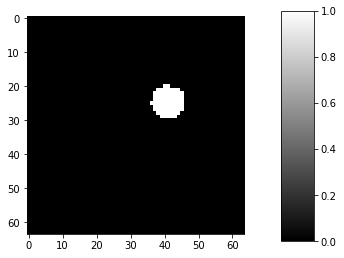

In [35]:
imagesc(A[3,:,:])

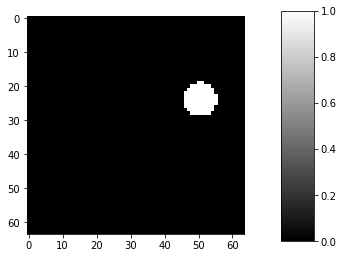

In [36]:
imagesc(A[6,:,:])

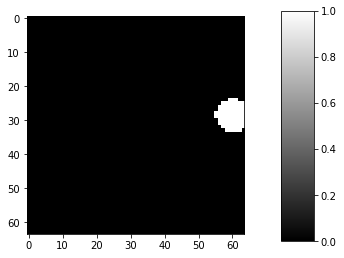

In [37]:
imagesc(A[9,:,:])

In [38]:
I1 = A[0,:,:].astype(np.float32);
I2 = A[1,:,:].astype(np.float32);

In [39]:
I1_8_bit = float2_bit(I1);
I2_8_bit = float2_bit(I2);

In [40]:
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create(nscales=1,epsilon=0.05,warps=1, innnerIterations = 10);
optical_flow.setLambda(0.005) #0.005 is the breaking point
t1 = time.time();
flow = optical_flow.calc(I1, I2, None);
# flow = optical_flow.calc(I1_8_bit, I2_8_bit, None);
t2 = time.time();

In [41]:
t2-t1

0.00051116943359375

In [42]:
u = flow[:,:,0];
v = flow[:,:,1];

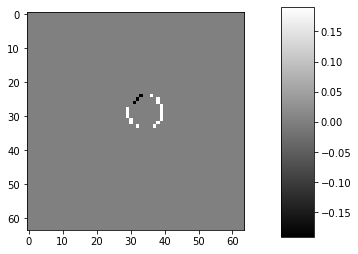

In [43]:
imagesc(u)

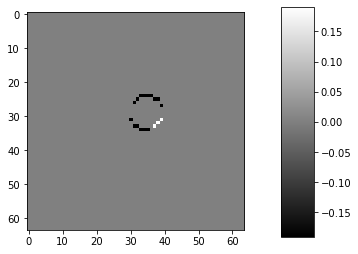

In [44]:
imagesc(v)

In [45]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");

I2_zero = warp_zero(I1,dt*flow);
I2_zero_check = warp_zero(I1,-dt*flow);
I2_un = warp_un(I1,dt*flow);
I2_un_check = warp_un(I1,-dt*flow);
I2_bis = warp_bis(I1,dt*flow);
I2_bis_check = warp_bis(I1,-dt*flow);

print("===========================================");
print("Warp error Skimage dt = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dt = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dt = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dt = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dt = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dt = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,dx*flow);
I2_zero_check = warp_zero(I1,-dx*flow);
I2_un = warp_un(I1,dx*flow);
I2_un_check = warp_un(I1,-dx*flow);
I2_bis = warp_bis(I1,dx*flow);
I2_bis_check = warp_bis(I1,-dx*flow);

print("===========================================");
print("Warp error Skimage dx = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dx = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dx = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dx = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dx = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dx = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,flow);
I2_zero_check = warp_zero(I1,-flow);
I2_un = warp_un(I1,flow);
I2_un_check = warp_un(I1,-flow);
I2_bis = warp_bis(I1,flow);
I2_bis_check = warp_bis(I1,-flow);

print("===========================================");
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");


Identity error = 9.110434
Warp error Skimage dt = 9.102113
Warp error Skimage -dt = 9.110434
Warp error scipy dt = 9.111059792909805
Warp error scipy -dt = 9.109741330761624
Warp error opencv dt = 9.110434
Warp error opencv -dt = 9.103678
Warp error Skimage dx = 9.109123
Warp error Skimage -dx = 9.110434
Warp error scipy dx = 9.110533904975753
Warp error scipy -dx = 9.110331636595886
Warp error opencv dx = 9.110434
Warp error opencv -dx = 9.110434
Warp error Skimage = 9.034174
Warp error Skimage = 9.110434
Warp error scipy = 9.114663465611548
Warp error scipy = 9.10007209927984
Warp error opencv = 9.110434
Warp error opencv = 9.0


In [46]:
t1 = time.time();
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 2, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 4 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 
t2 = time.time();

In [47]:
t2-t1

0.001756429672241211

In [48]:
u = flow[:,:,0];
v = flow[:,:,1];

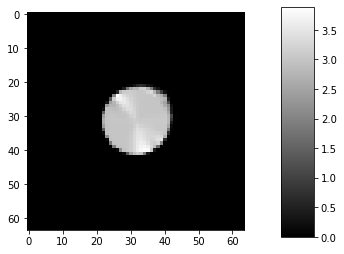

In [49]:
imagesc(u)

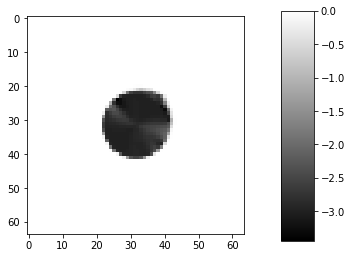

In [50]:
imagesc(v)

In [51]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");

I2_zero = warp_zero(I1,dt*flow);
I2_zero_check = warp_zero(I1,-dt*flow);
I2_un = warp_un(I1,dt*flow);
I2_un_check = warp_un(I1,-dt*flow);
I2_bis = warp_bis(I1,dt*flow);
I2_bis_check = warp_bis(I1,-dt*flow);

print("===========================================");
print("Warp error Skimage dt = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dt = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dt = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dt = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dt = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dt = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,dx*flow);
I2_zero_check = warp_zero(I1,-dx*flow);
I2_un = warp_un(I1,dx*flow);
I2_un_check = warp_un(I1,-dx*flow);
I2_bis = warp_bis(I1,dx*flow);
I2_bis_check = warp_bis(I1,-dx*flow);

print("===========================================");
print("Warp error Skimage dx = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dx = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dx = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dx = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dx = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dx = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,flow);
I2_zero_check = warp_zero(I1,-flow);
I2_un = warp_un(I1,flow);
I2_un_check = warp_un(I1,-flow);
I2_bis = warp_bis(I1,flow);
I2_bis_check = warp_bis(I1,-flow);

print("===========================================");
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");


Identity error = 9.110434
Warp error Skimage dt = 9.152072
Warp error Skimage -dt = 8.282663
Warp error scipy dt = 9.38700540360566
Warp error scipy -dt = 8.507870969693275
Warp error opencv dt = 9.15502
Warp error opencv -dt = 8.261725
Warp error Skimage dx = 9.08659
Warp error Skimage -dx = 8.956964
Warp error scipy dx = 9.171873951839688
Warp error scipy -dx = 9.038155580132386
Warp error opencv dx = 9.086205
Warp error opencv -dx = 8.958641
Warp error Skimage = 12.145712
Warp error Skimage = 2.0989835
Warp error scipy = 12.118529044318365
Warp error scipy = 1.6868653793637425
Warp error opencv = 12.020823
Warp error opencv = 9.0


In [52]:
np.random.seed(seed=1)
t1 = time.time();
flow = cv2.optflow.calcOpticalFlowSparseToDense(I1_8_bit, I2_8_bit, None); # Pas forcément top
t2 = time.time();

In [53]:
t2-t1

0.001687765121459961

In [54]:
u = flow[:,:,0];
v = flow[:,:,1];

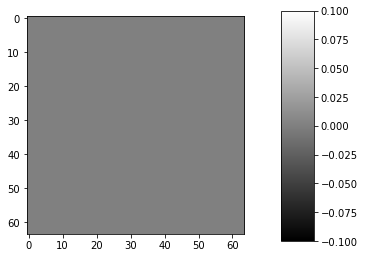

In [55]:
imagesc(u)

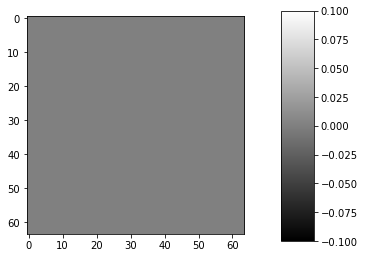

In [56]:
imagesc(v)

In [57]:
print("===========================================");
print("Identity error = " + str(np.linalg.norm(I2-I1)));
print("===========================================");

I2_zero = warp_zero(I1,dt*flow);
I2_zero_check = warp_zero(I1,-dt*flow);
I2_un = warp_un(I1,dt*flow);
I2_un_check = warp_un(I1,-dt*flow);
I2_bis = warp_bis(I1,dt*flow);
I2_bis_check = warp_bis(I1,-dt*flow);

print("===========================================");
print("Warp error Skimage dt = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dt = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dt = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dt = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dt = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dt = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,dx*flow);
I2_zero_check = warp_zero(I1,-dx*flow);
I2_un = warp_un(I1,dx*flow);
I2_un_check = warp_un(I1,-dx*flow);
I2_bis = warp_bis(I1,dx*flow);
I2_bis_check = warp_bis(I1,-dx*flow);

print("===========================================");
print("Warp error Skimage dx = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage -dx = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy dx = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy -dx = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv dx = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv -dx = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");

I2_zero = warp_zero(I1,flow);
I2_zero_check = warp_zero(I1,-flow);
I2_un = warp_un(I1,flow);
I2_un_check = warp_un(I1,-flow);
I2_bis = warp_bis(I1,flow);
I2_bis_check = warp_bis(I1,-flow);

print("===========================================");
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero)));
print("Warp error Skimage = " + str(np.linalg.norm(I2-I2_zero_check)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un)));
print("Warp error scipy = " + str(np.linalg.norm(I2-I2_un_check)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis)));
print("Warp error opencv = " + str(np.linalg.norm(I2-I2_bis_check)));
print("===========================================");


Identity error = 9.110434
Warp error Skimage dt = 9.110434
Warp error Skimage -dt = 9.110434
Warp error scipy dt = 9.1104335791443
Warp error scipy -dt = 9.1104335791443
Warp error opencv dt = 9.110434
Warp error opencv -dt = 9.110434
Warp error Skimage dx = 9.110434
Warp error Skimage -dx = 9.110434
Warp error scipy dx = 9.1104335791443
Warp error scipy -dx = 9.1104335791443
Warp error opencv dx = 9.110434
Warp error opencv -dx = 9.110434
Warp error Skimage = 9.110434
Warp error Skimage = 9.110434
Warp error scipy = 9.1104335791443
Warp error scipy = 9.1104335791443
Warp error opencv = 9.110434
Warp error opencv = 9.0


It seems to compute that `I3_check ` is the correct one

# Visualising the results

In [58]:
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create(nscales=1,epsilon=0.05,warps=1, innnerIterations = 10);
optical_flow.setLambda(0.005) #0.005 is the breaking point
flow = optical_flow.calc(I1, I2, None);

In [59]:
flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 2, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 4 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 

In [60]:
I2_zero_check = warp_zero(I1,-flow);

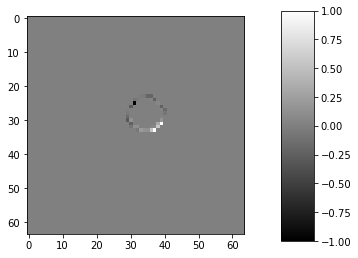

In [61]:
imagesc(I2-I2_zero_check)

In [62]:
np.amax(1/dx*flow)

249.21904

In [63]:
np.linalg.norm(I1-I2)

9.110434

In [64]:
np.linalg.norm(I2-I2_zero_check)

2.0989835

In [65]:
# A = next(iter(testloader));
# x = A[0][0,:,:,:,:];
# I1 = torch2numpy(x[3,0,:,:]);
# I2 = torch2numpy(x[4,0,:,:]);

# I1_8_bit = float2_bit(I1);
# I2_8_bit = float2_bit(I2);

In [66]:
# flow = cv2.calcOpticalFlowFarneback(I1_8_bit, I2_8_bit, None, 0.5, 3, 2, 3, 5, 1.2, 0) # None = flow, 0.5 = pyramid scale, 3 = number of pyramid layers, 4 = window_size,  3 = niter, 5 = size of the pixel neighborhood used to find polynomial expansion 

In [67]:
# I2_zero_check = warp_zero(I1,-flow);

In [68]:
# imagesc(I2-I2_zero_check)